In [ ]:
# Fastai vision tools (images, models, training, etc.)
from fastai.vision.all import *
# Fix random seed for reproducibility
set_seed(42)
# Fastcore parallel utils (speed up tasks with CPU cores)
from fastcore.parallel import *
# Fastai data utilities (datasets, dataloaders, pipelines)
from fastai.data.core import *
# PyTorch (tensors, GPU, models)
import torch
# Time module (to measure execution time)
import time

In [ ]:
# Import pandas for handling CSV files and dataframes
import pandas as pd
# Import Path to manage file paths in a clean way
from pathlib import Path
# Path to the training metadata CSV file
train_metadata_path = Path('/home/webadmin/Desktop/isic/train-metadata.csv')

In [6]:
# Looked at the sizes of the images to select the optimal one
# Takes a while so I just commented it 
'''from pathlib import Path
from PIL import Image
from collections import defaultdict

def get_image_sizes_and_counts(images_path):
    # Ensure images_path is a Path object
    images_path = Path(images_path)
    
    # Dictionary to store image sizes and their counts
    size_counts = defaultdict(int)
    
    # Iterate over all image files in the directory
    for img_path in images_path.glob('*'):
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                size_counts[(width, height)] += 1
        except Exception as e:
            print(f"Error opening {img_path}: {e}")
    
    return size_counts

# Define the path to your images
images_path = Path('/home/webadmin/Desktop/isic/image')

# Get all image sizes and their counts
size_counts = get_image_sizes_and_counts(images_path)

 # Convert dictionary to list of tuples and sort by count
sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)

# Get top 5 sizes
top_5_sizes = sorted_sizes[:5]

print(top_5_sizes)'''

'from pathlib import Path\nfrom PIL import Image\nfrom collections import defaultdict\n\ndef get_image_sizes_and_counts(images_path):\n    # Ensure images_path is a Path object\n    images_path = Path(images_path)\n    \n    # Dictionary to store image sizes and their counts\n    size_counts = defaultdict(int)\n    \n    # Iterate over all image files in the directory\n    for img_path in images_path.glob(\'*\'):\n        try:\n            with Image.open(img_path) as img:\n                width, height = img.size\n                size_counts[(width, height)] += 1\n        except Exception as e:\n            print(f"Error opening {img_path}: {e}")\n    \n    return size_counts\n\n# Define the path to your images\nimages_path = Path(\'/home/webadmin/Desktop/isic/image\')\n\n# Get all image sizes and their counts\nsize_counts = get_image_sizes_and_counts(images_path)\n\n # Convert dictionary to list of tuples and sort by count\nsorted_sizes = sorted(size_counts.items(), key=lambda x: x[1

Based on the code aboce top 5 are

	•   (133, 133): 21,049 images
	•	(131, 131): 20,906 images
	•	(129, 129): 20,379 images
	•	(135, 135): 20,364 images
	•	(137, 137): 19,256 images
    
so I took the standard size =137,137

# Cleaning metadata

In [7]:
# Load metadata append

df = pd.read_csv(train_metadata_path,low_memory=False)

# Drop specified columns
columns_to_drop = ['copyright_license', 'attribution', 'image_type', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4',
                       'iddx_5', 'iddx_full', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_tile_type', 
                       'tbp_lv_dnn_lesion_confidence', 'lesion_id']

# Define categorical and continuous columns
cat_names = [ 'sex', 'anatom_site_general', 'tbp_lv_location', 'tbp_lv_location_simple']
cont_names = [x for x in df.columns if x not in (cat_names + ['target', 'isic_id','patient_id']+columns_to_drop)]
y_col = 'target'
image_col = 'isic_id'

This code loads the training metadata from a CSV file, removes columns we don’t need, and separates the remaining data into categorical and numerical features.
It also sets the column for our prediction label (target) and the column that holds the image IDs (isic_id).
This setup makes the data ready for use in a machine learning or deep learning model.

In [8]:
def process_data(df, cat_names):
    
    
    # Drop columns 
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Add number of pictures for each patient
    df['numb_pic'] = df.groupby('patient_id')['patient_id'].transform('count')
    
    # Fill missing values with the mode
    if 'age_approx' in df.columns:
        mode_age = df['age_approx'].mode()[0]
        df['age_approx'] = df['age_approx'].fillna(mode_age)
    
    if 'sex' in df.columns:
        mode_sex = df['sex'].mode()[0]
        df['sex'] = df['sex'].fillna(mode_sex)
    
    # Convert categorical columns to dummies
    df = pd.get_dummies(df, columns=cat_names, prefix=cat_names)
    
    # Get new categorical column names
    new_cat_columns = [col for col in df.columns if any(col.startswith(name + '_') for name in cat_names)]
    
    # Ensure 'isic_id' in df has the correct file extension
    # if 'isic_id' in df.columns:
    #     df['isic_id'] = df['isic_id'].apply(lambda x: x.strip() + '.jpg')
    
    return df, new_cat_columns

#Apply to df
df, new_cat_columns= process_data(df,cat_names)  

In [ ]:
# Function to save a list of columns into a CSV file
def save_columns_to_csv(columns_list, file_path):
    df = pd.DataFrame(columns_list, columns=['new_cat_columns'])
    df.to_csv(file_path, index=False)

# Example usage
save_columns_to_csv(new_cat_columns, '/home/webadmin/Desktop/isic/new_cat_columns.csv')


I created a helper function to save the list of new categorical column names into a CSV file. This makes it easier to reuse or check which dummy variables were created during preprocessing. In this example, I save the new_cat_columns into a file called new_cat_columns.csv inside the ISIC folder.

# Oversampling

In [11]:
import h5py
import numpy as np
import random
from PIL import Image, ImageEnhance
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def augment_image(image_array, target_size=(137, 137)):
    # Convert numpy array to PIL image
    pil_image = Image.fromarray(image_array)
    
    # Randomly adjust hue, contrast, rotation, etc.
    if random.random() > 0.5:
        enhancer = ImageEnhance.Contrast(pil_image)
        pil_image = enhancer.enhance(random.uniform(0.8, 1.2))
    if random.random() > 0.5:
        enhancer = ImageEnhance.Color(pil_image)
        pil_image = enhancer.enhance(random.uniform(0.8, 1.2))
    if random.random() > 0.5:
        pil_image = pil_image.rotate(random.uniform(-10, 10), resample=Image.Resampling.BICUBIC, expand=True)
    
    # Resize the image to the target size without padding
    pil_image = pil_image.resize(target_size, resample=Image.Resampling.BICUBIC)
    
    # Convert PIL image back to numpy array
    return np.array(pil_image)

def resize_and_pad_image(image_array, standard_size=(137, 137)):
    if image_array.size == 0:
        raise ValueError("The image array is empty.")
    
    if len(image_array.shape) not in [2, 3]:
        raise ValueError(f"Unexpected image_array shape: {image_array.shape}")

    if image_array.ndim == 2:  # Grayscale image
        image_array = np.stack([image_array] * 3, axis=-1)
    elif image_array.ndim == 3 and image_array.shape[2] == 1:  # Single-channel image
        image_array = np.concatenate([image_array] * 3, axis=-1)
    
    old_size = image_array.shape[:2]  # original size (height, width)
    new_size = standard_size  # (width, height)

    if not isinstance(new_size, tuple) or len(new_size) != 2:
        raise ValueError(f"Expected standard_size to be a tuple of length 2, got {new_size}")

    if not old_size:
        raise ValueError("The old_size is empty. Cannot resize an image with unknown dimensions.")

    ratio = float(new_size[0]) / max(old_size)
    new_image_size = (int(old_size[1] * ratio), int(old_size[0] * ratio))

    if not isinstance(new_image_size, tuple) or len(new_image_size) != 2:
        raise ValueError(f"Expected new_image_size to be a tuple of length 2, got {new_image_size}")

    try:
        pil_image = Image.fromarray(image_array)
        resized_image = pil_image.resize(new_image_size, resample=Image.Resampling.LANCZOS)
        resized_image_array = np.array(resized_image)
        
        new_image = np.ones((new_size[1], new_size[0], image_array.shape[2]), dtype=np.uint8) * 255
        
        top = (new_size[1] - new_image_size[1]) // 2
        left = (new_size[0] - new_image_size[0]) // 2
        
        new_image[top:top + new_image_size[1], left:left + new_image_size[0]] = resized_image_array

    except Exception as e:
        print(f"Failed to process image: {e}")
        return np.zeros(standard_size + (image_array.shape[2],), dtype=np.uint8)  # Return a blank image if processing fails
    
    return new_image

def save_image_to_hdf5(hdf5_file, image_array, image_name, group_name):
    try:
        # Resize and pad the image
        image_array = resize_and_pad_image(image_array, standard_size=(137, 137))
        hdf5_file[group_name].create_dataset(image_name, data=image_array, compression="gzip", compression_opts=9)
        return image_name
    except Exception as e:
        print(f"Failed to save image {image_name}: {e}")
        return None

def read_image_from_folder(input_folder, img_name):
    img_path = f"{input_folder}/{img_name}.jpg"
    image = Image.open(img_path)
    return np.array(image)

def synthetic_oversample(df, column):
    # Replace this function with your synthetic oversampling logic
    return random.choice(df[column].values)

def oversample_data(input_folder, df, oversample_count=10000, undersample_count=10000, output_hdf5_path='oversampled_images.hdf5', batch_size=100):
    cancer_df = df[df['target'] == 1]
    non_cancer_df = df[df['target'] == 0].sample(n=undersample_count, random_state=42)

    # Oversample the minority class
    oversampled_rows = []
    cancer_len = len(cancer_df)
    for i in range(oversample_count - cancer_len):
        new_row = {}
        original_row = cancer_df.iloc[i % cancer_len]  # Reuse rows as needed
        new_row['isic_id'] = f"{original_row['isic_id']}_oversampled_{(i // cancer_len) + 1}"
        new_row['target'] = 1
        for column in df.columns:
            if column != 'isic_id' and column != 'target':
                new_row[column] = synthetic_oversample(cancer_df, column)
        oversampled_rows.append(new_row)
    
    oversampled_df = pd.DataFrame(oversampled_rows)
    combined_df = pd.concat([non_cancer_df, cancer_df, oversampled_df], ignore_index=True)

    # Save images to HDF5
    with h5py.File(output_hdf5_path, 'w') as hdf_out:
        hdf_out.create_group('oversampled_images')
        futures = []
        with ThreadPoolExecutor() as executor:
            # Process non-cancer and original cancer images
            for i in range(0, len(combined_df), batch_size):
                batch_files = combined_df['isic_id'].tolist()[i:i + batch_size]
                for img_name in tqdm(batch_files, desc=f"Processing batch {i // batch_size + 1}"):
                    try:
                        if '_oversampled_' not in img_name:  # Original images
                            img_data = read_image_from_folder(input_folder, img_name)
                        else:  # Augmented images
                            original_img_name = img_name.split('_oversampled_')[0]
                            img_data = read_image_from_folder(input_folder, original_img_name)
                            img_data = augment_image(img_data)
                        
                        futures.append(executor.submit(save_image_to_hdf5, hdf_out, img_data, img_name, 'oversampled_images'))
                    except Exception as e:
                        print(f"Failed to process image {img_name}: {e}")
                
                for future in as_completed(futures):
                    future.result()

    return combined_df

Implemented the oversampling pipeline to handle class imbalance. First, I created helper functions to resize, pad, and augment images. Augmentations include random changes in contrast, color, and rotation. All images are resized to 137x137 for consistency.

The main function oversample_data balances the dataset by:

Undersampling the majority class (non-cancer images).

Oversampling the minority class (cancer images) by creating extra synthetic rows.

Augmenting cancer images and saving them with new IDs like _oversampled_1.

Finally, all images are stored in an HDF5 file for efficient loading. This creates a balanced dataset of original and oversampled images, making the model less biased toward the majority class.

In [ ]:
from pathlib import Path
# Input images folder
input_folder = Path("/home/webadmin/Desktop/isic/image")
# Oversampled HDF5 file will be saved
output_hdf5_path = Path("/home/webadmin/Desktop/isic/Oversampled_small.hdf5")
# Make sure the output folder exists
output_hdf5_path.parent.mkdir(parents=True, exist_ok=True)


In [14]:
# Balance dataset by over/under sampling and save as HDF5

# Folder with original training images
input_folder = Path("/home/webadmin/Desktop/isic/image")

# Path to save balanced dataset
output_hdf5_path = Path("/home/webadmin/Desktop/isic/Oversampled_small.hdf5")

# Perform oversampling/undersampling and save result
combined_df = oversample_data(
    input_folder,
    df,
    undersample_count=100000,
    oversample_count=10000,
    output_hdf5_path=output_hdf5_path
)


Processing batch 1100: 100%|██████████| 100/100 [00:00<00:00, 577.60it/s]


In [15]:
# Save balanced DataFrame to CSV
csv_path = Path("/home/webadmin/Desktop/isic/Small_df5.csv")
combined_df.to_csv(csv_path, index=False)

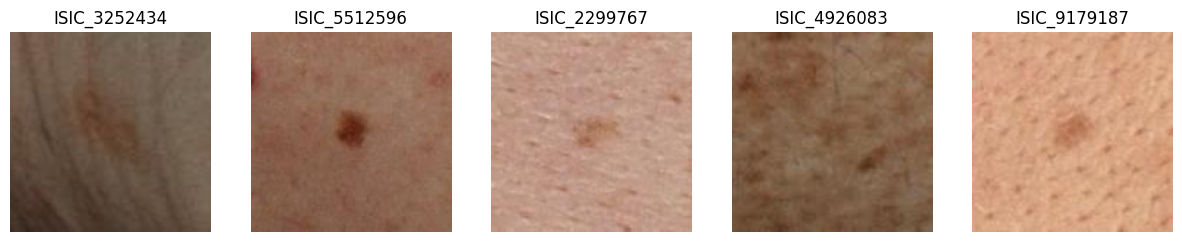

In [16]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random

def show_random_images_from_hdf5(hdf5_path, num_images=5):
    """
    Display a random sample of images from an HDF5 file.

    :param hdf5_path: Path to the HDF5 file.
    :param num_images: Number of random images to display.
    """
    try:
        with h5py.File(hdf5_path, 'r') as hdf_file:
            # Get all image keys from the HDF5 file
            image_keys = list(hdf_file['oversampled_images'].keys())
            
            if len(image_keys) < num_images:
                raise ValueError(f"Not enough images in the HDF5 file to display {num_images} images.")
            
            # Randomly select a subset of image keys
            selected_keys = random.sample(image_keys, num_images)
            
            fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
            if num_images == 1:
                axes = [axes]
            
            for ax, key in zip(axes, selected_keys):
                # Load image data from the HDF5 file
                img_data = hdf_file['oversampled_images'][key][()]
                ax.imshow(img_data)
                ax.set_title(key)
                ax.axis('off')
            
            plt.show()
    
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
show_random_images_from_hdf5(output_hdf5_path)

This function opens the HDF5 file, picks a few random images from "oversampled_images", and displays them using matplotlib. It first collects all image keys, randomly selects the required number, loads each image, and shows them without axes. If there’s an error, it prints a message.


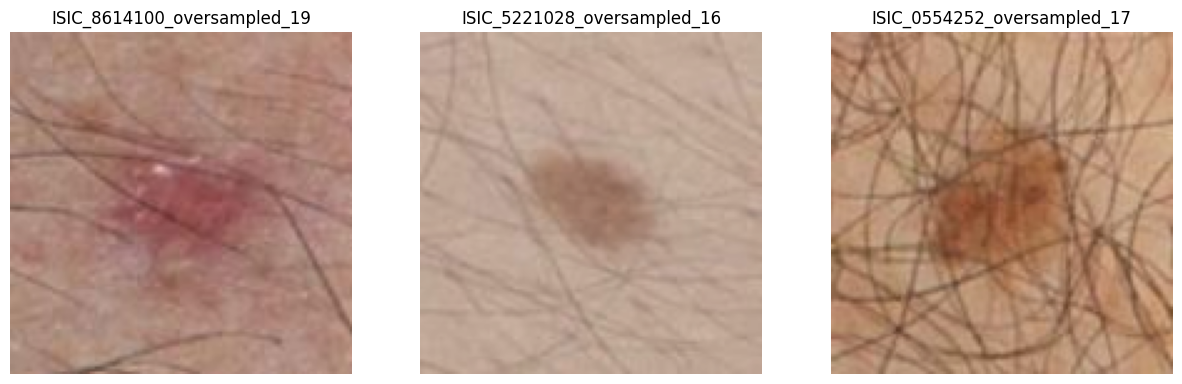

In [25]:
import h5py
def show_random_oversampled_images_from_hdf5(hdf5_path, num_images=3, suffix="_oversampled_1"):
    ''''
    Display a random sample of oversampled images from an HDF5 file.
    
    :param hdf5_path: Path to the HDF5 file.
    :param num_images: Number of random images to display.
    :param suffix: Suffix used to identify oversampled images.
    '''
    try:
        with h5py.File(hdf5_path, 'r') as hdf_file:
            # Get all image keys from the HDF5 file
            image_keys = list(hdf_file['oversampled_images'].keys())
            
            # Filter keys to only include those with the suffix indicating they are oversampled
            oversampled_keys = [key for key in image_keys if suffix in key]
            
            if len(oversampled_keys) < num_images:
                raise ValueError(f"Not enough oversampled images in the HDF5 file to display {num_images} images.")
            
            # Randomly select a subset of oversampled image keys
            selected_keys = random.sample(oversampled_keys, num_images)
            
            fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
            if num_images == 1:
                axes = [axes]
            
            for ax, key in zip(axes, selected_keys):
                # Load image data from the HDF5 file
                img_data = hdf_file['oversampled_images'][key][()]
                ax.imshow(img_data)
                ax.set_title(key)
                ax.axis('off')
            
            plt.show()
    
    except Exception as e:
        print(f"An error occurred: {e}")
output_hdf5_path = Path("/home/webadmin/Desktop/isic/Oversampled_small.hdf5")

# Example usage
show_random_oversampled_images_from_hdf5(output_hdf5_path)

This function is similar to the previous one, but it specifically shows only oversampled images from the HDF5 file. It looks for image keys that contain the _oversampled_1 suffix (or any suffix you specify). A random selection of those images is displayed with their IDs as titles.

In [26]:
# Show only rows where 'isic_id' contains '_oversampled_'
combined_df[combined_df['isic_id'].str.contains('_oversampled_')]

,isic_id,target,patient_id,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_lv_location_Torso Front Top Half,tbp_lv_location_Unknown,tbp_lv_location_simple_Head & Neck,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
100393,ISIC_0082829_oversampled_1,1,IP_4545121,80.0,1.65,29.635242,11.511600,18.176476,19.319361,49.423478,...,False,False,True,False,False,False,False,False,False,False
100394,ISIC_0096034_oversampled_1,1,IP_3346083,55.0,1.82,23.199550,15.975310,18.505185,27.657042,34.337380,...,False,False,False,False,False,False,False,False,False,False
100395,ISIC_0104229_oversampled_1,1,IP_7299252,65.0,7.12,26.867286,25.344073,13.681880,30.249502,39.317260,...,False,False,False,False,False,False,False,False,False,False
100396,ISIC_0119495_oversampled_1,1,IP_9009251,75.0,3.98,22.882080,15.646850,21.781311,31.741682,29.744670,...,False,False,False,False,False,False,False,False,False,False
100397,ISIC_0157834_oversampled_1,1,IP_3026867,70.0,3.74,21.957160,18.651922,11.467240,31.239777,30.418507,...,False,False,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,ISIC_4614975_oversampled_25,1,IP_1474479,45.0,7.49,25.831590,24.962728,26.343781,27.831520,33.458754,...,False,False,True,False,False,False,False,True,False,False
109996,ISIC_4620217_oversampled_25,1,IP_5092630,60.0,3.12,26.187010,18.645457,17.968160,26.788100,34.166220,...,False,False,True,False,False,False,False,False,False,False
109997,ISIC_4629159_oversampled_25,1,IP_4934005,60.0,1.23,23.064301,19.675285,22.764530,18.841432,29.451924,...,False,False,False,False,False,False,False,True,False,False
109998,ISIC_4654372_oversampled_25,1,IP_5799983,60.0,12.89,25.084586,21.564292,28.698530,20.541780,38.636924,...,False,False,False,False,False,False,False,True,False,False


This filters the DataFrame to display only the oversampled images by checking if "_oversampled_" is part of the isic_id value.

In [27]:
# Display the entire DataFrame
combined_df

,isic_id,target,patient_id,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_lv_location_Torso Front Top Half,tbp_lv_location_Unknown,tbp_lv_location_simple_Head & Neck,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
0,ISIC_9153490,0,IP_7069393,60.0,2.60,21.007710,18.016330,30.218970,29.328780,36.803670,...,False,False,False,False,False,True,False,False,False,False
1,ISIC_0157465,0,IP_2331257,55.0,3.30,17.035806,12.847501,32.962708,29.559866,37.104701,...,False,False,False,False,False,True,False,False,False,False
2,ISIC_6306355,0,IP_4540594,65.0,6.05,21.838689,18.534150,32.950961,32.294894,39.530926,...,False,False,False,False,False,False,False,True,False,False
3,ISIC_2358370,0,IP_9726832,85.0,2.52,20.954890,14.262520,34.401940,31.152540,40.281520,...,False,False,False,False,False,False,False,False,True,False
4,ISIC_1565789,0,IP_7293666,65.0,3.10,26.657570,8.635016,19.921980,20.644660,33.279290,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,ISIC_4614975_oversampled_25,1,IP_1474479,45.0,7.49,25.831590,24.962728,26.343781,27.831520,33.458754,...,False,False,True,False,False,False,False,True,False,False
109996,ISIC_4620217_oversampled_25,1,IP_5092630,60.0,3.12,26.187010,18.645457,17.968160,26.788100,34.166220,...,False,False,True,False,False,False,False,False,False,False
109997,ISIC_4629159_oversampled_25,1,IP_4934005,60.0,1.23,23.064301,19.675285,22.764530,18.841432,29.451924,...,False,False,False,False,False,False,False,True,False,False
109998,ISIC_4654372_oversampled_25,1,IP_5799983,60.0,12.89,25.084586,21.564292,28.698530,20.541780,38.636924,...,False,False,False,False,False,False,False,True,False,False


This shows all rows and columns in the combined_df DataFrame

In [28]:
 def count_datasets(name, obj, counter):
    """Recursively count the datasets in the HDF5 file."""
    if isinstance(obj, h5py.Group):
        for key, item in obj.items():
            count_datasets(f"{name}/{key}", item, counter)
    elif isinstance(obj, h5py.Dataset):
        counter[0] += 1

def print_hdf5_structure_and_count(file_path):
    """Open an HDF5 file, print its structure, and count the total number of images (datasets)."""
    with h5py.File(file_path, 'r') as f:
        print("HDF5 file structure:")
        dataset_count = [0]
        for key in f.keys():
            count_datasets(key, f[key], dataset_count)
        print(f"\nTotal number of images: {dataset_count[0]}")

# Example usage
print_hdf5_structure_and_count('/home/webadmin/Desktop/isic/Oversampled_small.hdf5')



HDF5 file structure:

Total number of images: 110000


This opens the HDF5 file, walks through every group and dataset, and counts how many datasets (images) exist. The counter list is used so the count can be updated inside the recursive function. Finally, it prints the total number of images found.

In [29]:
# Count 0s and 1s in the 'target' column
target_counts = combined_df['target'].value_counts().sort_index()
# Print count of 0s
print(f"Negative (0): {target_counts.get(0, 0)}")
# Print count of 1s
print(f"Positive (1): {target_counts.get(1, 0)}")
# Print total count
print(f"Total: {target_counts.sum()}")


Negative (0): 100000
Positive (1): 10000
Total: 110000


This code checks how many negative (0) and positive (1) labels are in the 'target' column of the dataset.  

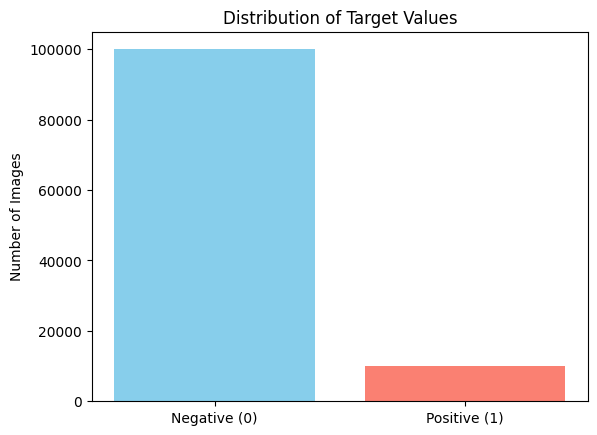

In [30]:
import matplotlib.pyplot as plt

# Count 0s and 1s in target column
counts = combined_df['target'].value_counts().sort_index()

# Bar chart
plt.bar(['Negative (0)', 'Positive (1)'], counts, color=['skyblue', 'salmon'])
plt.title('Distribution of Target Values')
plt.ylabel('Number of Images')
plt.show()
